In [1]:
from adversarial_lab.core import ALModel
from adversarial_lab.core.noise_generators import AdditiveNoiseGenerator
from adversarial_lab.attacks.whitebox import WhiteBoxMisclassification
from adversarial_lab.core.preprocessing import PreprocessingFromFunction
from adversarial_lab.utils import Plotting
from adversarial_lab.core.constraints import POClip, PONoisedSampleBounding

from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

In [2]:
model = InceptionV3(weights='imagenet')


def preprocess(sample, *args, **kwargs):
    input = tf.cast(sample, dtype=tf.float32)
    if len(input.shape) == 2:
        input = tf.expand_dims(input, axis=-1)
        input = tf.image.grayscale_to_rgb(input)

    elif len(input.shape) == 3 and input.shape[-1] == 1:
        input = tf.image.grayscale_to_rgb(input)

    input_tensor = tf.convert_to_tensor(input, dtype=tf.float32)
    resized_image = tf.image.resize(input_tensor, (299, 299))
    batch_image = tf.expand_dims(resized_image, axis=0)
    return preprocess_input(batch_image)


pp = PreprocessingFromFunction.create(preprocess)

In [3]:
image = Image.open('data/panda.jpg')
image_array = np.array(image)

np.argmax(model.predict(pp.preprocess(image_array)), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([388], dtype=int64)

In [4]:
from adversarial_lab.analytics import AdversarialAnalytics, ImageTracker, LossTracker, PredictionsTracker, NoiseTracker
from adversarial_lab.db.sqllite import SqlliteDB

db = SqlliteDB(db_path="wb.db")
analytics = AdversarialAnalytics(db,
                                 [
                                     LossTracker(track_batch=False),
                                     ImageTracker(),
                                     PredictionsTracker(),
                                     NoiseTracker()
                                 ],
                                 "test",
                                 True)

In [5]:
from adversarial_lab.core.losses import CategoricalCrossEntropy
from adversarial_lab.core.penalties import LpNorm
from adversarial_lab.core.optimizers import PGD

optim = PGD(learning_rate=1.0)

loss = CategoricalCrossEntropy()

In [6]:
con1 = POClip(min=-2, max=2)
con2 = PONoisedSampleBounding(min=0, max=255)

In [7]:
ng = AdditiveNoiseGenerator(scale=[0, 255], dist="zeros")

In [ ]:
attacker = WhiteBoxMisclassification(
    model, optim, loss, noise_generator=ng, constraints=[con1, con2], preprocessing=pp, analytics=analytics, verbose=3)

Attacking: 100%|██████████| 5/5 [00:42<00:00,  8.58s/it, Loss=0.141, Prediction (score)=924(0.968), Original Class (score)=388(0.004), Target Class (score)=924(0.968)]


In [14]:
noise = attacker.attack(image_array, target_class=924,
                        epochs=5, strategy="random", on_original=True)

Attacking: 100%|██████████| 5/5 [00:10<00:00,  1.87s/it, Loss=0.266, Prediction (score)=924(0.973), Original Class (score)=388(0.004), Target Class (score)=924(0.973)]

In [15]:
print(np.min(image_array+noise[0]), np.max(image_array+noise[0]))
print(np.min(noise[0]), np.max(noise[0]))

-2.0 257.0
-2.0 2.0


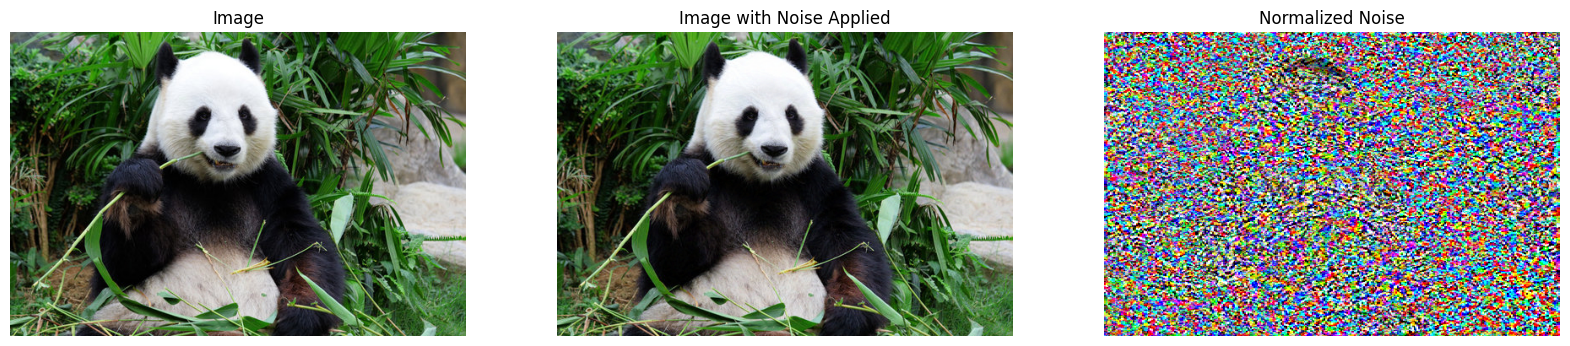

In [11]:
Plotting.plot_images_and_noise(image_array, noise[0])